In [1]:
__author__ = "Alexandru Paraschiv"

""" This notebook analyses the chances of a student to be accepted to graduate school. The data 
set considers factors such as cummulative GPA, TOEFL score, GRE score and university reputation.
The dataset contains an initial exploratory data analysis (EDA) and then some predictive models 
such as  Multivariate Linear Regression, K-Nearest Neighbours, SVM Regression and Random Forest.
The accuracy of each model is analysed using the mean squared error as a  perfomance metric.
The random forest model is used to infer the features importance. 

The analysis reveals that in order to increase the chances of being admitted to a graduate school,
a prospective candidate should primarily focus on obtaining high marks in his/her undergraduate 
studies as  well as good GRE and TOEFL scores. The unquantifiable requirements such as the quality 
of the letter of recommendation  and statement of purpose have a lower impact and should not be given
as much importance. Interestingly, having carried out undergraduate research did not significantly 
increased a candidate's chances of being admitted.
"""

""" The data set was downloaded from https://www.kaggle.com/mohansacharya/graduate-admissions"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from tqdm import tqdm

//anaconda/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("admissions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
Serial No.           500 non-null int64
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(5)
memory usage: 35.2 KB


In [3]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
df = df.drop(['Serial No.'],axis=1) 

In [5]:
# check if there are any missing values in the dataset (NaN or None values)
df.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

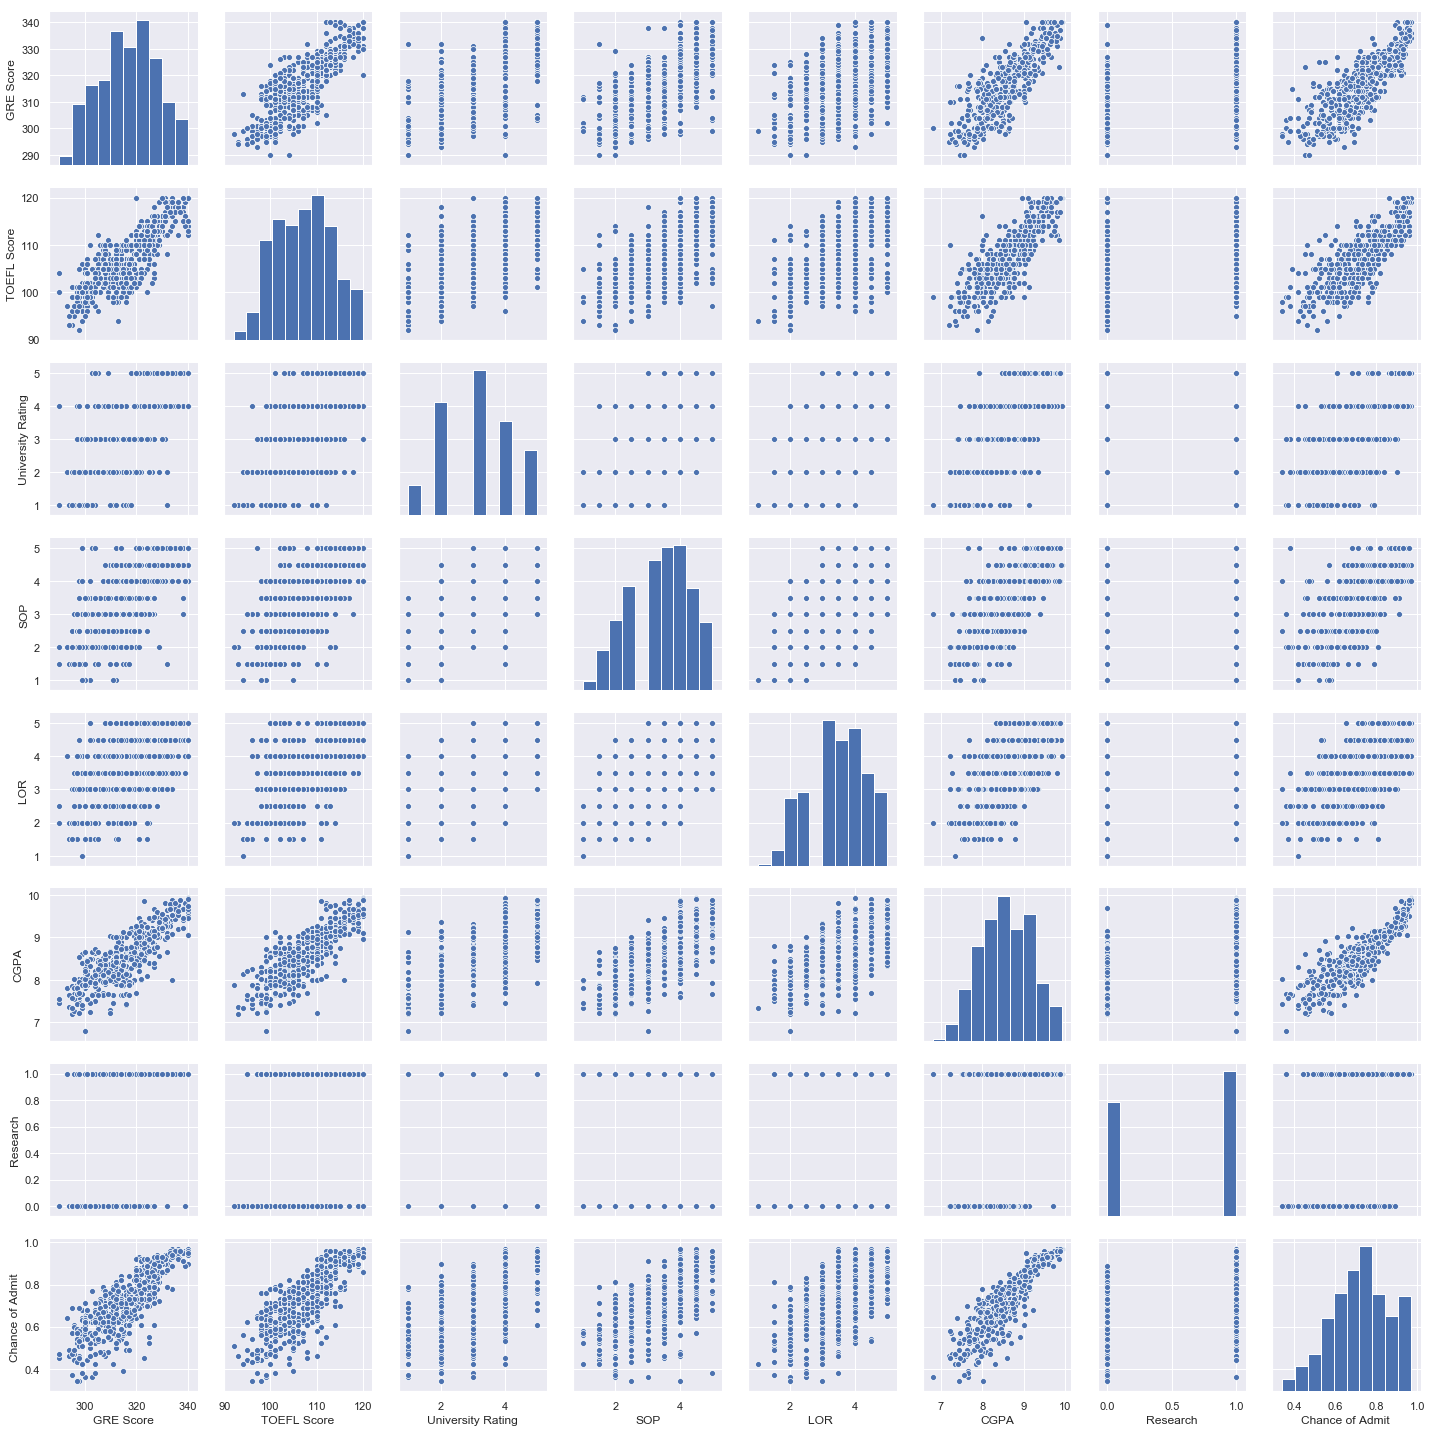

In [6]:
"""A quick glance at the pairplot reveals the following: Most features follow a normal 
distribution as expected (GRE score, TOEFL score, university rating, GPA). The chance of 
admission is slightly skewed toward the right tail (almost all students have some 
reasonable chance  of being admittted, but there are fewer who have a higher chance of
being admitted at prestigious universities.) The data has no significant outliers""" 

sns.pairplot(df)

In [7]:
toefl_score = df['TOEFL Score'];
gre_score = df['GRE Score'];
university_rating = df['University Rating']
cgpa = df['CGPA']
research = df['Research']
chance_of_admit = df[df.columns[-1]];

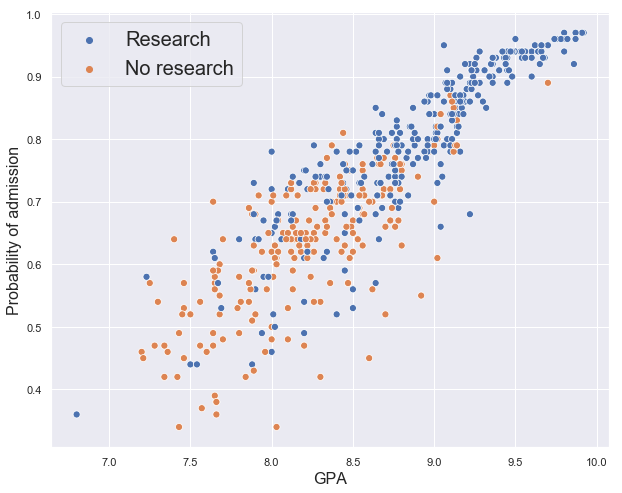

In [8]:
# A simple scatter plot of the chance of admission against the GPA. 
# It seems that the higher the GPA leads to higher the chances of admission. 
# Students who have a high GPA are more likely to have carried out research.

plt_colours = ["cornflowerblue","lightsalmon"]
colours = [plt_colours[0] if research[i] else plt_colours[1] for i in range(research.size)]
research_array = np.asarray(['Research' if research[i] else 'No research' for i in range(research.size)])



plt.figure(figsize=(10,8))
sns.scatterplot(cgpa,chance_of_admit,c=colours,s=50,hue=research_array)
plt.xlabel("GPA",fontsize=16)
plt.ylabel("Probability of admission",fontsize=16)
plt.legend(fontsize=20)
plt.show()

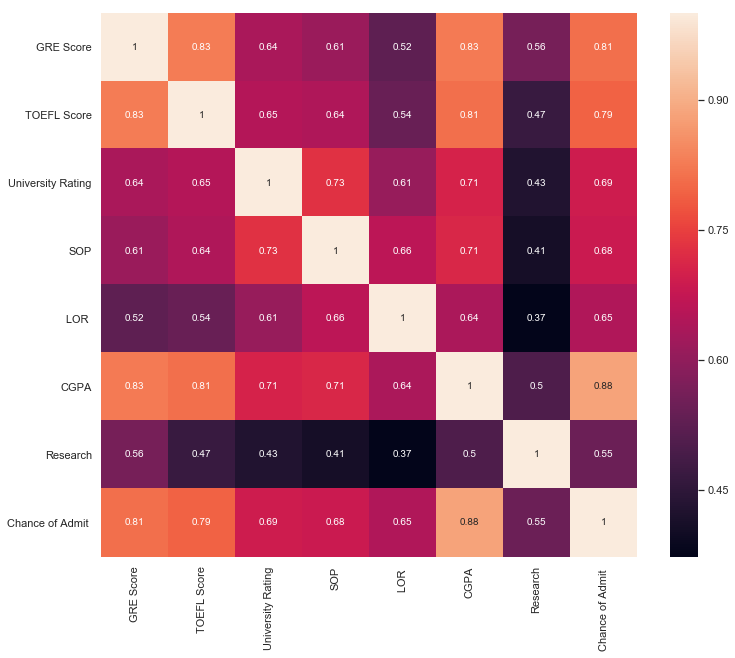

In [9]:
""" The correlation plot show a high correlation between most features. 
That is to be expected as stronger students will generally test better across 
different exams (TOEFL, GRE) and they will also achieve a higher GPA. Interestingly,
research has the least correlation with the chance of being admitted. """

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True)


In [10]:
y = chance_of_admit 
X = df.drop(['Chance of Admit '],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rf = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=400)
rf.fit(X,y)
print(rf.score)


<bound method RegressorMixin.score of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)>


In [11]:
y_pred = rf.predict(X_test)

In [12]:
"""The parameters of the random forest can be improved via a random search of the parameter space 
with crossvalidation. The code is adapted from 
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74"""

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}



# A random grid will be used to tune the model's hyper parameters with three folds for crossvalidation
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)
rf_random_error = mean_squared_error(y_pred,y_test)

In [13]:
print(rf_random_error)

0.0038461748706377376


In [14]:
# Get the best parameters from the randomized search
rf_random.best_params_


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [15]:
print(rf_random.best_estimator_.feature_importances_)

[0.24414282 0.1701706  0.09204758 0.08310813 0.04726659 0.33765791
 0.02560638]


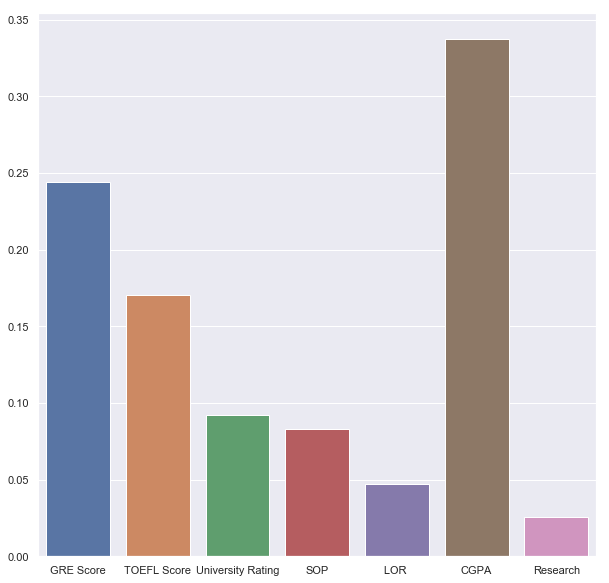

In [16]:
plt.figure(figsize=(10,10))
sns.barplot(x=X.columns, y=rf_random.best_estimator_.feature_importances_)


In [17]:
"""It does seem that the cummulative GPA is the most important factor by far in the
university admissions. The data set is highly multicollinear, as strong students tend 
to achieve a high GPA as well as high GRE and TOEFL scores. It seems that the statement 
of purpose and letters of reccomandation are generally not very important. Research showed
the least correlation, however the majority of the better students had carried out research 
as well. It seems that the best strategy for getting into a strong graduate program would 
be to focus primarily on GPA and then on TOEFL and GRE. Interestingly, the university ranking 
is not very important so candidates should not beintimidated to apply to higher rated universities."""

'It does seem that the cummulative GPA is the most important factor by far in the\nuniversity admissions. The data set is highly multicollinear, as strong students tend \nto achieve a high GPA as well as high GRE and TOEFL scores. It seems that the statement \nof purpose and letters of reccomandation are generally not very important. Research showed\nthe least correlation, however the majority of the better students had carried out research \nas well. It seems that the best strategy for getting into a strong graduate program would \nbe to focus primarily on GPA and then on TOEFL and GRE. Interestingly, the university ranking \nis not very important so candidates should not beintimidated to apply to higher rated universities.'

In [18]:
"""Potential improvements: Using higher complexity algorithms, boosted trees (XGBoost, LightGBM)
Investigate how to deal with high multicollinearity, maybe use PCA for dimensionality reduction. 

A few notes about potential weaknesses of the data set: the data is collected only for students 
from an Engineering background so there is some considerable selection bias in the data. I do not 
believe the model should be used by students in other departments.
It is not clear to me how the probability of admission is inferred initially.
The rating of the letter of reccomandation , and .

As a summary, in order to get admitted to a good grad school, a candidate should maximise the quantifiables:
the GPA (most important), the GRE score and the TOEFL score. The letter of recommendation """

'Potential improvements: Using higher complexity algorithms, boosted trees (XGBoost, LightGBM)\nInvestigate how to deal with high multicollinearity, maybe use PCA for dimensionality reduction. \n\nA few notes about potential weaknesses of the data set: the data is collected only for students \nfrom an Engineering background so there is some considerable selection bias in the data. I do not \nbelieve the model should be used by students in other departments.\nIt is not clear to me how the probability of admission is inferred initially.\nThe rating of the letter of reccomandation , and .\n\nAs a summary, in order to get admitted to a good grad school, a candidate should maximise the quantifiables:\nthe GPA (most important), the GRE score and the TOEFL score. The letter of recommendation '

In [19]:
y = chance_of_admit 
X = df.drop(['Chance of Admit '],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
rf = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=400)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred1 = rf.predict(X)
rf_error = mean_squared_error(y_pred,y_test)

In [20]:
print(rf_error)

0.004491937450665327


In [21]:
lr =  LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_pred2 = lr.predict(X)
lr_error = mean_squared_error(y_pred,y_test)

The residuals set has a skew of 1.8485696546076416


//anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


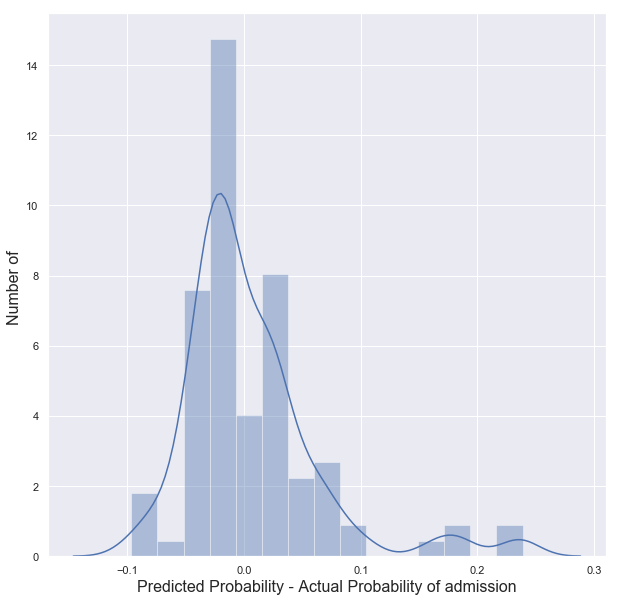

In [22]:
plt.figure(figsize=(10,10))
sns.distplot((y_pred - y_test).values)
print("The residuals set has a skew of {}".format(skew((y_pred - y_test).values, axis=0)))
np.mean((y_pred - y_test).values)
# most residuals are centred around 0 with a few outliers at around 0.2
# the residuals show a normal-like distribution
# the predicted values are higher than the test, with a positive skew
plt.xlabel("Predicted Probability - Actual Probability of admission",fontsize=16)
plt.ylabel("Number of ",fontsize=16)

In [23]:
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
knn_error = mean_squared_error(y_pred,y_test)

# this seems to work fine, although I would expect
# standardization of the features to be required...
# should look at the inner implementation of KNNRegressor,
# I wonder if it does something like elbow analysis under the hood 
# or requires further hyperparameter tuning

In [24]:
svm = SVR()
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
svm_error = mean_squared_error(y_pred,y_test)

# standardization should improve performance

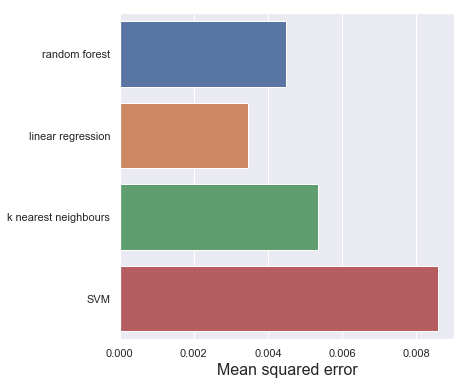

In [25]:
errors = [rf_error, lr_error,knn_error,svm_error]
error_names = ['random forest','linear regression','k nearest neighbours','SVM']

plt.figure(figsize=(6,6))
fig = sns.barplot(x=errors, y=error_names,)
plt.xlabel("Mean squared error", fontsize=16)

# We plot the performance of the models "straight out of the box"

In [26]:
""" Interestingly, the simple linear mode performs better than the other models.
It is thus preferable to use because of its interpretability. These results can potentially
be improved by reducing overfitting, ie. via L2 regularization in the case of the linear
regression or hyperparameter tuning in the case of the other methods. We will exemplify 
this in the case of random forest."""


' Interestingly, the simple linear mode performs better than the other models.\nIt is thus preferable to use because of its interpretability. These results can potentially\nbe improved by reducing overfitting, ie. via L2 regularization in the case of the linear\nregression or hyperparameter tuning in the case of the other methods. We will exemplify \nthis in the case of random forest.'

100%|██████████| 49/49 [00:00<00:00, 690.28it/s]


k = 4 has the optimal value


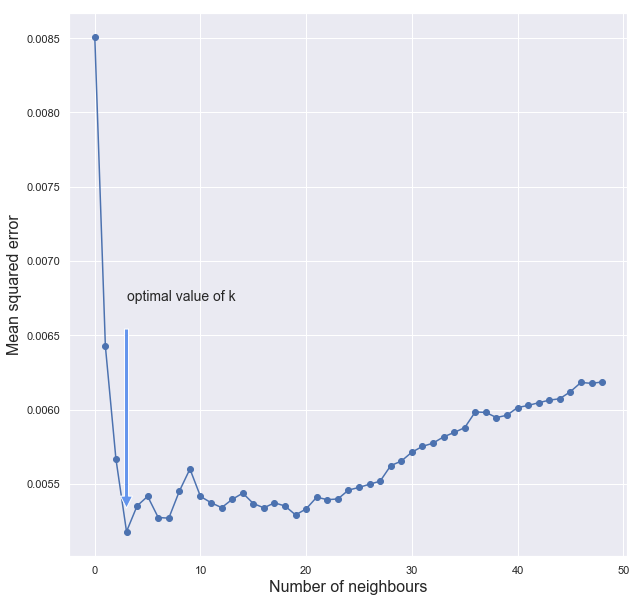

In [27]:
# Elbow method for choosing the right K in nearest neighbours regressor
mses = []
for i in tqdm(range(1,50)):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    knn_error = mean_squared_error(y_pred,y_test)
    mses.append(knn_error)
mses = np.asarray(mses)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.plot(mses,marker='o')
plt.xlabel("Number of neighbours",fontsize=16)
plt.ylabel("Mean squared error",fontsize=16)
ax.annotate('optimal value of k', xy=(np.argmin(mses), 1.001*np.min(mses)), 
            xytext=(np.argmin(mses), 1.3*np.min(mses)),
            arrowprops=dict(facecolor='cornflowerblue', shrink=0.1),size=14
            )

print ("k = {} has the optimal value".format(np.argmin(mses)+1))